In [1]:
import json
import os
from qmap.toolkit import aligner
from qmap.toolkit import split
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import EsmTokenizer, EsmModel
from pyutils import progress
from sklearn.linear_model import LinearRegression
from pyutils import Colors
import pickle
from scipy.stats import pearsonr
COLORS = ['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E', "#ADFF2F", "#FF8200"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)
plt.rcParams.update({'font.size': 14})

/Users/anthonylavertu/mac_docs/pycharmProjects/QMAP/split_experiment/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../data/build/dataset.json', 'r') as f:
    dataset = json.load(f)
dataset = [sample for sample in dataset if len(sample['Sequence']) <= 100]
dataset[0].keys()

dict_keys(['ID', 'Sequence', 'N Terminus', 'N Terminus Name', 'C Terminus', 'C Terminus Name', 'Unusual Amino Acids', 'Unusual Amino Acids Names', 'Targets', 'Hemolitic Activity', 'Cytotoxic Activity'])

# ML prediction
To assert the best splitting threshold, we will generate embeddings using ESM2 650M and use a linear regressor to predict the log MIC values. We will try different thresholds and plot the test performances.

In [3]:
def generate_esm2_embeddings(protein_sequences: list[str],
                             model_name: str = "facebook/esm2_t33_650M_UR50D",
                             device: str = None,
                             batch_size: int = 1) -> np.ndarray:
    """
    Generate protein embeddings using ESM2 model with mean pooling.

    Args:
        protein_sequences (List[str]): List of protein sequences (amino acid sequences)
        model_name (str): Name of the ESM2 model to use. Options include:
            - "facebook/esm2_t6_8M_UR50D" (8M parameters)
            - "facebook/esm2_t12_35M_UR50D" (35M parameters)
            - "facebook/esm2_t30_150M_UR50D" (150M parameters)
            - "facebook/esm2_t33_650M_UR50D" (650M parameters) - default
            - "facebook/esm2_t36_3B_UR50D" (3B parameters)
            - "facebook/esm2_t48_15B_UR50D" (15B parameters)
        device (str): Device to run the model on ('cuda', 'cpu', or None for auto-detection)
        batch_size (int): Batch size for processing sequences

    Returns:
        np.ndarray: Array of shape (num_sequences, embedding_dim) containing embeddings
                   in the same order as input sequences
    """

    # Set device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load tokenizer and model
    tokenizer = EsmTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name)
    model.to(device)
    model.eval()

    all_embeddings = []

    # Process sequences in batches
    for i in progress(range(0, len(protein_sequences), batch_size)):
        batch_sequences = protein_sequences[i:i + batch_size]

        # Tokenize sequences
        inputs = tokenizer(batch_sequences,
                           return_tensors="pt",
                           padding=True,
                           truncation=True,
                           max_length=1024)

        # Move to device
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Process each sequence in the batch
        for j in range(len(batch_sequences)):
            # Get attention mask for this sequence (to exclude padding tokens)
            attention_mask = inputs['attention_mask'][j]
            seq_embeddings = hidden_states[j][attention_mask.bool()]  # Remove padding

            # Remove special tokens (CLS and EOS tokens)
            seq_embeddings_no_special = seq_embeddings[1:-1]  # Remove first (CLS) and last (EOS) tokens

            # Mean pooling
            seq_embedding = seq_embeddings_no_special.mean(dim=0)
            all_embeddings.append(seq_embedding.cpu().numpy())

    return np.array(all_embeddings)

In [4]:
if not os.path.exists(".cache/esm2_embeddings.npy"):
    embs = generate_esm2_embeddings([sample["Sequence"] for sample in dataset], batch_size=128, device="mps")
    np.save(".cache/esm2_embeddings.npy", embs)
else:
    embs = np.load(".cache/esm2_embeddings.npy")

In [13]:
# Note: takes 2 to 3h to run on my M4 MB
thresholds = [0.3, 0.4, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.8, 0.9, 0.99]
if os.path.exists(".cache/pcc_trains.npy") and os.path.exists(".cache/pcc_tests.npy"):
    pcc_trains = np.load(".cache/pcc_trains.npy")
    pcc_tests = np.load(".cache/pcc_tests.npy")
else:
    # Try different thresholds
    pcc_trains = np.empty((len(thresholds), 5))
    pcc_tests = np.empty((len(thresholds), 5))
    for i, threshold in enumerate(thresholds):
        for j in range(5 if threshold != 0.3 else 1):
            train_seq, test_seq, train_embs, test_embs, train_samples, test_samples = split.train_test_split(
                [sample["Sequence"] for sample in dataset],
                embs,
                dataset,
                threshold=threshold,
                post_filtering=True,
                n_iterations=2
            )
            print(f"Train size: {len(train_seq)}, Test size: {len(test_seq)}")
            while len(train_seq) < 3000:
                train_seq, test_seq, train_embs, test_embs, train_samples, test_samples = split.train_test_split(
                    [sample["Sequence"] for sample in dataset],
                    embs,
                    dataset,
                    threshold=threshold,
                    post_filtering=True,
                    n_iterations=2
                )
                print(f"Train size: {len(train_seq)}, Test size: {len(test_seq)}")

            train_y = np.array([sample['Targets']['Escherichia coli'][0] if 'Escherichia coli' in sample['Targets'] else np.nan for sample in train_samples])
            train_y[np.isinf(train_y)] = np.nan
            mask = ~np.isnan(train_y)
            train_y = np.log10(train_y[mask])
            train_embs = np.array(train_embs)[mask]
            indices = np.arange(len(train_y))
            np.random.shuffle(indices)
            indices = indices[:3000]
            train_y = train_y[indices]
            train_embs = train_embs[indices]

            test_y = np.array([sample['Targets']['Escherichia coli'][0] if 'Escherichia coli' in sample['Targets'] else np.nan for sample in test_samples])
            test_y[np.isinf(test_y)] = np.nan
            mask = ~np.isnan(test_y)
            test_y = np.log10(test_y[mask])
            test_embs = np.array(test_embs)[mask]

            # Make a linear regression model
            reg = LinearRegression()
            reg.fit(train_embs, train_y)

            pcc_train = pearsonr(reg.predict(train_embs), train_y).statistic
            pcc_test = pearsonr(reg.predict(test_embs), test_y).statistic
            if threshold == 0.3:
                pcc_trains[i, :] = pcc_train
                pcc_tests[i, :] = pcc_test
            else:
                pcc_trains[i, j] = pcc_train
                pcc_tests[i, j] = pcc_test
            print(f'{Colors.orange} - [it {j}]', threshold, pcc_train, pcc_test, f'{Colors.reset}')
    np.save(".cache/pcc_trains.npy", pcc_trains)
    np.save(".cache/pcc_tests.npy", pcc_tests)

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 0.52 it/s eta 00:00
Found 4 clusters in the dataset.
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  10/10 it 0.70 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  28/28 it 0.55 it/s eta 00:00
Train size: 1494, Test size: 4705
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 0.54 it/s eta 00:00
Found 4 clusters in the dataset.
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  10/10 it 0.73 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  28/28 it 0.56 it/s eta 00:00
Train size: 1494, Test size: 4705
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 0.55 it/s eta 00:00
Found 4 clusters in the dataset.
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  18/18 it 0.75 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  20/20 it 0.49 it/s eta 00:00
Train size: 239, Test size: 8860
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 599f36d8-0caf-4a0c-914e-78efaa00368c)')' thrown while requesting HEAD https://huggingface.co/anthol42/qmap/resolve/main/config.json
Retrying in 1s [Retry 1/5].


Found 3787 clusters in the dataset.


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ba8f05a4-293d-499c-b1cc-a1a98c763932)')' thrown while requesting HEAD https://huggingface.co/anthol42/qmap/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /anthol42/qmap/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1415a8b90>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 269601a1-ed7c-4c2c-9288-d41f0bb26249)')' thrown while requesting HEAD https://huggingface.co/anthol42/qmap/resolve/main/config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /anthol42/qmap/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConn

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  8/8 it 0.13 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  30/30 it 0.31 it/s eta 00:00
Train size: 14782, Test size: 4003
 - [it 4] 0.7 0.8313573618385579 0.29793432556937643 
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 0.53 it/s eta 00:00
Found 4781 clusters in the dataset.
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  8/8 it 0.62 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  30/30 it 0.58 it/s eta 00:00
Train size: 15145, Test size: 3825
 - [it 0] 0.75 0.8310511202569357 0.2367706000511851 
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 0.54 it/s eta 00:00
Found 4782 clusters in the dataset.
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  8/8 it 0.58 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  30/30 it 0.59 it/s eta 00:00
Train size: 15154, Test size: 3810
 - [it 1] 0.75 0.8581401140901038 0.1789677279671012 
Encod

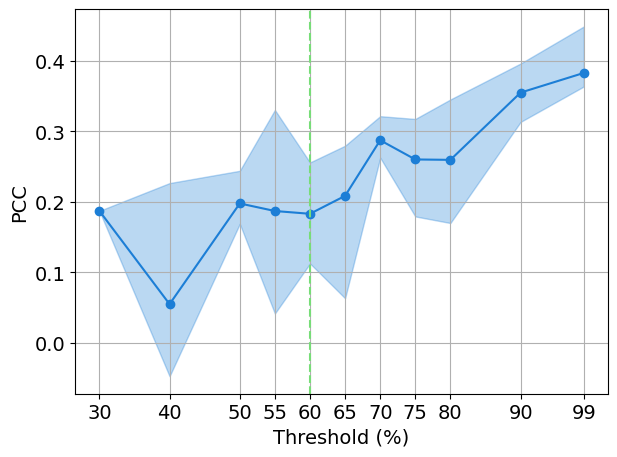

In [14]:
# plt.plot(thresholds, np.median(pcc_trains, axis=1), label='Train PCC', marker='o')
# plt.figure(figsize=(8, 4))
plt.plot(thresholds, np.mean(pcc_tests, axis=1), label='Test PCC', marker='o')
# plt.fill_between(thresholds, np.max(pcc_trains, axis=1), np.min(pcc_trains, axis=1), color="tab:blue", alpha=0.3)
plt.fill_between(thresholds, np.max(pcc_tests, axis=1), np.min(pcc_tests, axis=1), color=COLORS[0], alpha=0.3)

# Add a vertical line at the threshold of 0.55
plt.axvline(x=0.60, color=COLORS[1], linestyle='--', label='Threshold 0.60')
plt.xlabel('Threshold (%)')
plt.ylabel('PCC')
plt.xticks(thresholds, [f'{t:.2f}'[2:] for t in thresholds])
plt.grid()
# plt.title('PCC vs splitting threshold')
plt.tight_layout()
plt.savefig(".cache/figs/pcc_vs_threshold.svg")

# Real world distance
Next, we aim to evaluate the distances of real world sequences to the DBAASP database to get a sense of the real world distance between any sequence and the training set.

In [7]:
# Read the peptide atlas data and we will compare its distance to the DBAASP database to get a sense of the real world distance between sequences
def read_fasta(file_path):
    """
    Reads a FASTA file and returns a list of tuples containing sequence IDs and sequences.
    :param file_path: The path to the FASTA file.
    :return:
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    sequences = []
    for line in lines:
        if line.startswith('>'):
            id_ = line[1:].strip()
        else:
            sequence = line.strip()
            sequences.append((id_, sequence))
    return sequences
peptide_atlas = read_fasta("../peptide_atlas/.cache/peptide_atlas.fasta")

In [8]:
# ~1h to run
if not os.path.exists('.cache/tmp_atlas.pkl'):
    encoder = aligner.Encoder()
    atlas_db = encoder.encode([seq for _, seq in peptide_atlas])
    with open('.cache/tmp_atlas.pkl', 'wb') as f:
        pickle.dump(atlas_db, f)
else:
    with open('.cache/tmp_atlas.pkl', 'rb') as f:
        atlas_db = pickle.load(f)

In [9]:
# Takes around 2h to run on M4 MBP
# Compute the max identity between atlas and dbaasp sequences
max_iden_natural = np.empty(len(atlas_db))
if not os.path.exists(".cache/max_iden.npy"):
    encoder = aligner.Encoder(force_cpu=True)
    dbaasp_db = encoder.encode([sample['Sequence'] for sample in dataset])
    activation = encoder.activation
    activation.half()
    with torch.inference_mode():
        for i, (seq, emb) in enumerate(progress(atlas_db)):
            iden = torch.max(activation(dbaasp_db.embeddings @ emb.unsqueeze(1)))
            max_iden_natural[i] = iden.item()
        np.save(".cache/max_iden.npy", max_iden_natural)
else:
    max_iden_natural = np.load(".cache/max_iden.npy")


Quantiles:
- 0.01 quantile: 0.343505859375
- 0.05 quantile: 0.363037109375
- 0.10 quantile: 0.375
- 0.25 quantile: 0.3974609375
- 0.50 quantile: 0.42822265625
- 0.75 quantile: 0.4658203125
- 0.90 quantile: 0.505859375
- 0.95 quantile: 0.533203125
- 0.99 quantile: 0.59326171875


(array([1.12234123e-04, 0.00000000e+00, 4.86347867e-04, 2.61879621e-04,
        7.10816113e-04, 1.94539147e-03, 5.38723791e-03, 1.55631317e-02,
        4.34346057e-02, 1.20277569e-01, 2.86870419e-01, 5.86947053e-01,
        1.13831589e+00, 1.89993665e+00, 2.81299865e+00, 4.01633551e+00,
        5.19262394e+00, 6.09726839e+00, 7.18803442e+00, 7.87442090e+00,
        8.00872774e+00, 8.41595055e+00, 8.31149799e+00, 7.77771250e+00,
        7.61781629e+00, 7.11381025e+00, 6.31496517e+00, 5.94867041e+00,
        5.33059709e+00, 4.54978430e+00, 4.17608208e+00, 3.60877600e+00,
        3.07547685e+00, 2.72901012e+00, 2.21258350e+00, 1.88815207e+00,
        1.68676664e+00, 1.31182984e+00, 1.08986816e+00, 9.58479412e-01,
        7.52866498e-01, 6.11077389e-01, 5.37564039e-01, 4.08419974e-01,
        3.39470811e-01, 2.92295068e-01, 2.21924273e-01, 1.79836477e-01,
        1.54621210e-01, 1.19529341e-01, 9.78681554e-02, 8.41007696e-02,
        6.23273497e-02, 5.16651080e-02, 4.33597829e-02, 3.475516

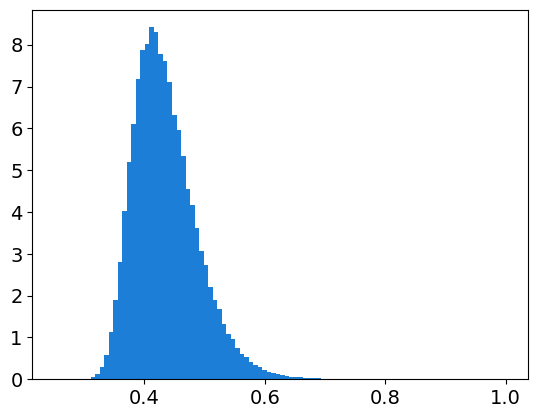

In [10]:
# This distribution is equivalent to a random split with a threshold of 0.55
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(max_iden_natural, q)}")
plt.hist(max_iden_natural, bins=100, density=True)

In [11]:
np.quantile(max_iden_natural, [0.5, 0.75, 0.9, 0.95, 0.99])

array([0.42822266, 0.46582031, 0.50585938, 0.53320312, 0.59326172])